# Using spectrogram cross-correlation to detect blue whale calls




<div style="float: left">
    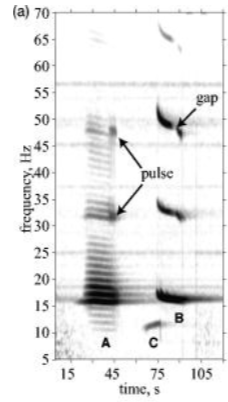
</div>


North East Pacific blue whales have distinct calls which are split into several segments. The spectrogram shows the A, B, and C call harmonics of the NEP blue whale (Dunn and Hernandez, 2009). The B call is the most powerful of the three, and is often the only one visible when a call is recorded of a whale some distance away from the recording instrument. For that reason, the B call is used to detect the whales acoustically. The relative consistency of blue whale call frequency modulation allows us to automatically detect calls through spectrogram cross correlation.

For this exercise, we are using data from a ocean-bottom seismometer with a sample rate of 50 Hz. Keep in mind that you can only resolve signals of frequenies up to 1/2 the sample rate of an instrument. This is called the Nyquist frequency. Frequencies higher than the Nyquist frequency are aliased.

In the markdown box below, please answer the following questions:

**1)**
What is the Nyquist frequency of this ocean bottom seismometer if it samples at 50 Hz? On the figure, notice which B call harmonic will be visible below the Nyquist.


**2)**
Predict: Why do you think we use spectrogram cross-correlation to detect blue whale calls rather than 1-D waveform cross-correlation?



### Reading .wav files and viewing whale calls

In the box below we will import essential python libraries for reading data from a .wav file and making figures.

In [ ]:
import os
import scipy.io.wavfile as siow
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import matplotlib.colors as color
import matplotlib.animation as animation

Next, we will read a .wav file from a github repository into a numpy array. In the next code box, specify the path to your downloaded tutorial folder on your computer:

In [ ]:
os.chdir('/Users/wader/Geohackweek/whale-detection') #specifiy the path to your local repo here

In the next cell, we define a function called 
*plotwave*
which will make the timeseries and spectrogram plots. Once this function is defined, we simply need to call the function plotwave(samp, data) in later cells to produce a new figure.

In [ ]:
def plotwav(samp, data): #defines the plotwav function used later to plot timeseries and spectrograms
    
    [b,a] = sig.butter(4,[8/samp, 20/samp],'bandpass','ba') #filter data to spectral bands where B-call is
    data1 = sig.filtfilt(b, a, data)

    
    datalength = data.size
    times = np.arange(datalength)/samp

    #plot timeseries on upper axis
    plt.figure(1, figsize=(9, 3))
    plt.subplot(211)
    plt.plot(times[10:],data1[10:])
    plt.axis([min(times), max(times), min(data1[10:]), max(data1[10:])])
    plt.xlabel('Seconds')
    plt.ylabel('Amplitude')

    #plot spectrogram on lower axis
    [f, t, Sxx] = sig.spectrogram(data1, samp, 'hann',samp*4,int(samp*3.8))
    cmap = plt.get_cmap('magma')
    norm = color.Normalize(vmin=np.amin(np.log10(Sxx))+12, vmax=np.amax(np.log10(Sxx)))
    plt.subplot(212)
    plt.pcolormesh(t, f, np.log10(Sxx), cmap=cmap, norm=norm)    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([12, 18])
    return [f, t, Sxx]




First, let's look at some strong blue whale calls. We will read the .wav file containing recordings of blue whale B calls that were emmitted close to our sensor. We will make two plots. The top plot will show the raw waveform measured by the sensor, and the bottom will show a spectrogram of the same data.

Spectrograms can be difficult to understand at first. They show the changes in power recorded at different frequencies over time. Dark colors represent low power, while bright colors represent high power. You can think of reading the changes in frequency over time like a musical score! 

The following commands will load 'strongCalls.wav' and plot it's contents. 

In [ ]:
[samp, data] = siow.read('strongCalls.wav', mmap=False)
[f, t, Sxx] =plotwav(samp, data)

Next we will look at some weak blue whale calls. Run the cell below, and note the diffrences between the strong call and weak call waveform plots and spectrogram plots. Observe that the weak A calls have faded away, and while the weak B calls are distinct on the spectrogram they are indistinct in the waveform.

In [ ]:
[samp, data] = siow.read('weakCalls.wav', mmap=False)
[f, t, Sxx] =plotwav(samp, data)

Do these observations support your answer to question 2? if not, refine your answer.

# How is a spectrogram cross-correlator implemented?

To build a spectrogram cross-correlator to detect calls automatically, a synthetic call image must be built which is representative of the average call. The term for this synthetic call is a kernel. 
Like in waveform cross-correlation, the spectrogram and the sample are slid past each other, multiplying matching components in the set of overlapping frames together. Then, to produce a single detection score for each frame of overlap, the resulting matrix of values is summed together.



Let's look at an example kernel that was built to detect bowhead whales.

<div style="float: left">
    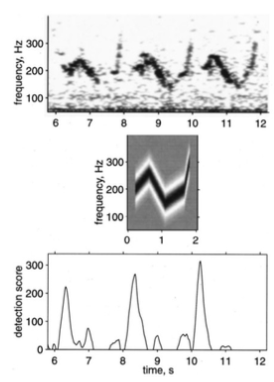
</div>

The upper left image shows three successive bowhead whale calls (Mellinger and Clark, 2000).

The middle image shows the kernel that was developed to detect bowhead whale calls through spectrogram cross- correlation. The kernel is <div style="float: right">
    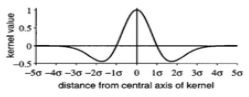
</div> built with repeating "hat functions" (right figure) parallel to the y axis. The area under the positive section is equal to the area under the two negative sections. This prevents non-whale signals which cross the frequency band of the kernel from giving large spikes in the detection score. Dark areas of the kernel to the left represent positive values, light areas represent negative values, and grey areas represent values near zero.


The lower image shows the detection score of each overlapping frame as the kernel is moved across the spectrogram.

## Building a blue whale call kernel

**3)** 
Blue whale B calls have simpler frequency modulation than bowhead whales. Look at the call spectrograms you produced again. Briefly describe of what you think the shape of a blue whale B call kernel should look like.


Answer:

The best shape for a blue whale B call kernel is a simple downswept linear segment. The figures below show zoomed in plots of each strong B call so you can look at it's characteristics. We will build a blue whale call kernel based on measurements you take of the call.

**4)**
Using all 3 displayed calls, estimate and record these parameters:

• Average call length (in seconds)

• Average call start frequency

• Average call end frequency

• Average bandwidth (for these purposes defined as the width of the call in the frequency domain, divided by 2)


<div style="float: left">
    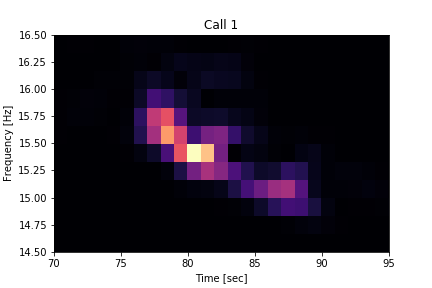
</div>

<div style="float: left">
    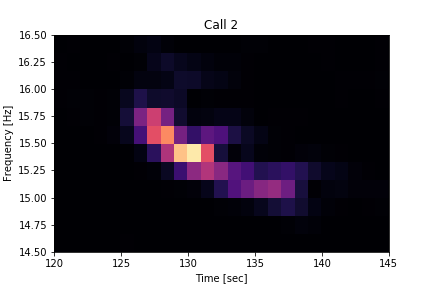
</div>

<div style="float: left">
    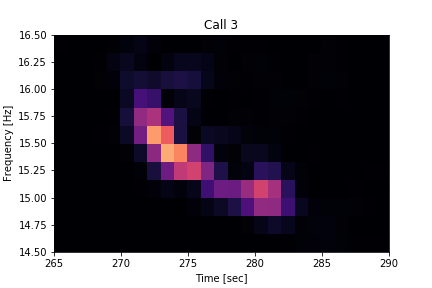
</div>


Next we will define a function that will build a kernel to cross-correlate with our spectrograms to detect blue whale calls. You will call this function with inputs of your estimated parameters from measuring these calls.

In [ ]:
def buildkernel(f0, f1, bdwdth, dur, f, t, samp):
    tvec = np.linspace(0,dur,np.size(np.nonzero(t < dur))) #define kernel as length dur
    fvec = f #define frequency span of kernel to match spectrogram
    Kdist = np.zeros((np.size(tvec), np.size(fvec))) #preallocate space for kernel values
    j=0
    for j in range(np.size(tvec)):
        #calculate hat function that is centered on linearly decresing
        #frequency values for each time in tvec
        x = fvec-(f0+(t[j]/dur)*(f1-f0))
        Kval = (1-np.square(x)/(bdwdth*bdwdth))*np.exp(-np.square(x)/(2*(bdwdth*bdwdth)))
        Kdist[j] = Kval #store hat function values in preallocated array
                                                           
    BlueKernel = np.transpose(Kdist) #transpose preallocated array to be plotted vs. tvec and fvec
    return [tvec, fvec, BlueKernel]

In the code box below, input your calculated values from inspecting the zoomed calls. 

f0 = average start frequency 

f1 = average end frequency 

bdwdth = average bandwidth 

dur = average duration

Run the code box, and the function *buildkernel* will build your kernel tuned to your specified parameters.

In [ ]:
f0 = 15.7 #average start frequency
f1 = 14.4 #average end frequency
bdwdth = 0.5 # average bandwidth
dur = 10 #average duration
[tvec, fvec, BlueKernel] = buildkernel(f0, f1, bdwdth, dur, f, t, samp) #build kernel from input parameters
plt.pcolormesh(tvec, fvec, BlueKernel) #show plot of kernel
plt.axis([0, 10, 0, 25])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Blue whale B-call kernel')

Congratulations on creating your first blue whale detection kernel! Like the kernel for detecting right whales described above, this kernel has positive values in the shape of the expected whale call, negative values bounding it to prevent false positives from signals outside of the expected range, and zero values everywhere else.

## Cross-correlating our kernel and our spectrogram

The next code chunk will read a .wav file, and make a spectrogram of 20,000 seconds of data in preparation for cross-correlation to test our detection kernel. Don't worry if you can't distinguish whale calls on this spectrogram- the time period is too long to resolve the calls on the small plot.

In [ ]:
[samp, data] = siow.read('Test_data.wav', mmap=False)
[f, t, Sxx] = plotwav(samp, data)


This next code cell we will cross-correlate the kernel and the spectrogram of our test dataset. We do this by "sliding" the kernel across the spectrogram and summing the element-wise multiplication of each overlapping frame. The results of our cross-correlation will give us as time series with a "detection score" for each point in time.

In [ ]:
ind1 = 0
CorrVal = np.zeros((np.size(t) - 39)) #preallocate array for correlation values
corrchunk= np.zeros((np.size(fvec), np.size(tvec))) #preallocate array for element-wise multiplication

while ind1-1+np.size(tvec) < np.size(t):
    ind2 = ind1 + np.size(tvec) #indices of spectrogram subset to multiply
    for indF in range(np.size(fvec)-1):
        corrchunk[indF] = Sxx[indF][ind1:ind2] #grab spectrogram subset for multiplication
        
    CorrVal[ind1] = np.sum(np.multiply(BlueKernel, corrchunk)) #save cross-correlation value for each frame
    ind1 += 1
    
    

Finally, we will plot the results of our cross-correlation! First, run the code below and notice the detection score value peaks on the top axis. 

If the kernel created by your parameters fails to produce coherent peaks in the detection score value, try making the kernel again with these values:

f0 = 15.7

f1 = 14.4

bdwdth = 0.5

dur = 10

Then, run the code again but zoom in on regions with high detection score value peaks by editing the values defined in t1 and t2. 

t1 = start time (seconds)
t2 = end time (seconds)

Zoom in on regions with smaller detection score value peaks. Can you find any peaks in the detection score that correspond to signals that are not blue whale B-calls? If you do find signals that cause high detection scores, can you think of any way to reduce their impact?


In [ ]:
t1=min(t)
t2=max(t)
#plot timeseries on upper axis
plt.figure(1, figsize=(9, 3))
plt.subplot(211)
plt.plot(t[19:-20],CorrVal/max(CorrVal)) #plot normalized detection scores as a time series.
plt.axis([t1, t2, 0, .4]) #look at only positive values
plt.xlabel('Seconds')
plt.ylabel('Detection score')
plt.title('Spectrogram and detection scores of test data')

#plot spectrogram on lower axis
cmap = plt.get_cmap('magma')
norm = color.Normalize(vmin=np.amin(np.log10(Sxx))+15, vmax=np.amax(np.log10(Sxx)))
plt.subplot(212)
plt.pcolormesh(t, f, np.log10(Sxx), cmap=cmap, norm=norm)   
plt.axis([t1, t2, 12, 18]) #look at spectrogram segment between given time boundaries
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [seconds]')




# Congrats!

Welcome to the world of signal detection!

**References**

 Mellinger, D. K., & Clark, C. W. (2000). Recognizing transient low-frequency whale sounds by spectrogram correlation. The Journal of the Acoustical Society of America J. Acoust. Soc. Am., 107(6), 3518. doi:10.1121/1.429434

Dunn, R. A., & Hernandez, O. (2009). Tracking blue whales in the eastern tropical Pacific with an ocean-bottom seismometer and hydrophone array. The Journal of the Acoustical Society of America J. Acoust. Soc. Am., 126(3), 1084. doi:10.1121/1.3158929